# Data Loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('/content/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


# Data Visualization

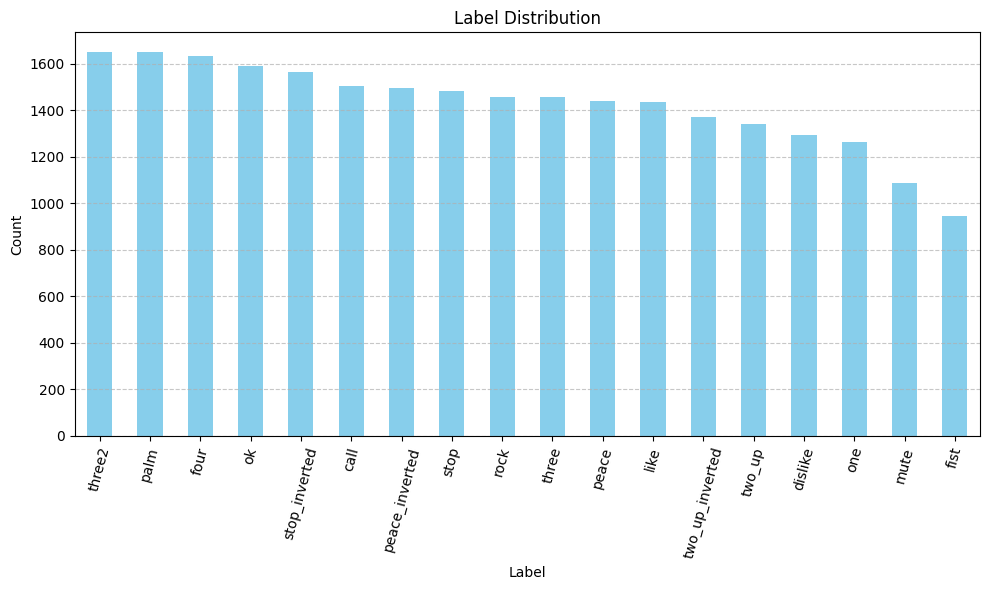

In [ ]:
# Explore and visualize the label distribution
sorted_df = df['label'].value_counts()

plt.figure(figsize=(10, 6))
sorted_df.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize an example for each label

def plot_hand_landmarks(samples):
  labels = samples['label'].unique()
  num_labels = len(labels)
  fig, axes = plt.subplots(nrows=3, ncols=(num_labels // 3) + (num_labels % 3), figsize=(20, 15))
  axes = axes.flatten()

  connections = [(0,1), (1,2), (2,3), (3,4),
               (0,5), (5,6), (6,7), (7,8),
               (5,9), (9,10), (10,11), (11,12),
               (9,13), (13,14), (14,15), (15,16),
               (13,17), (17,18), (18,19), (19,20)]

  for i, label in enumerate(labels):
    sample = samples[samples['label'] == label].iloc[0, :-1].values.reshape(21, 3)
    ax = axes[i]
    ax.scatter(sample[:, 0], sample[:, 1], color='blue')

    for j, (x, y) in enumerate(zip(sample[:, 0], sample[:, 1])):
        ax.text(x, y, str(j), fontsize=8, color="red")

    for connection in connections:
        pt1, pt2 = connection
        ax.plot([sample[pt1, 0], sample[pt2, 0]], [sample[pt1, 1], sample[pt2, 1]], 'skyblue')

    ax.set_title(f"Label: {label}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

  plt.tight_layout()
  plt.show()

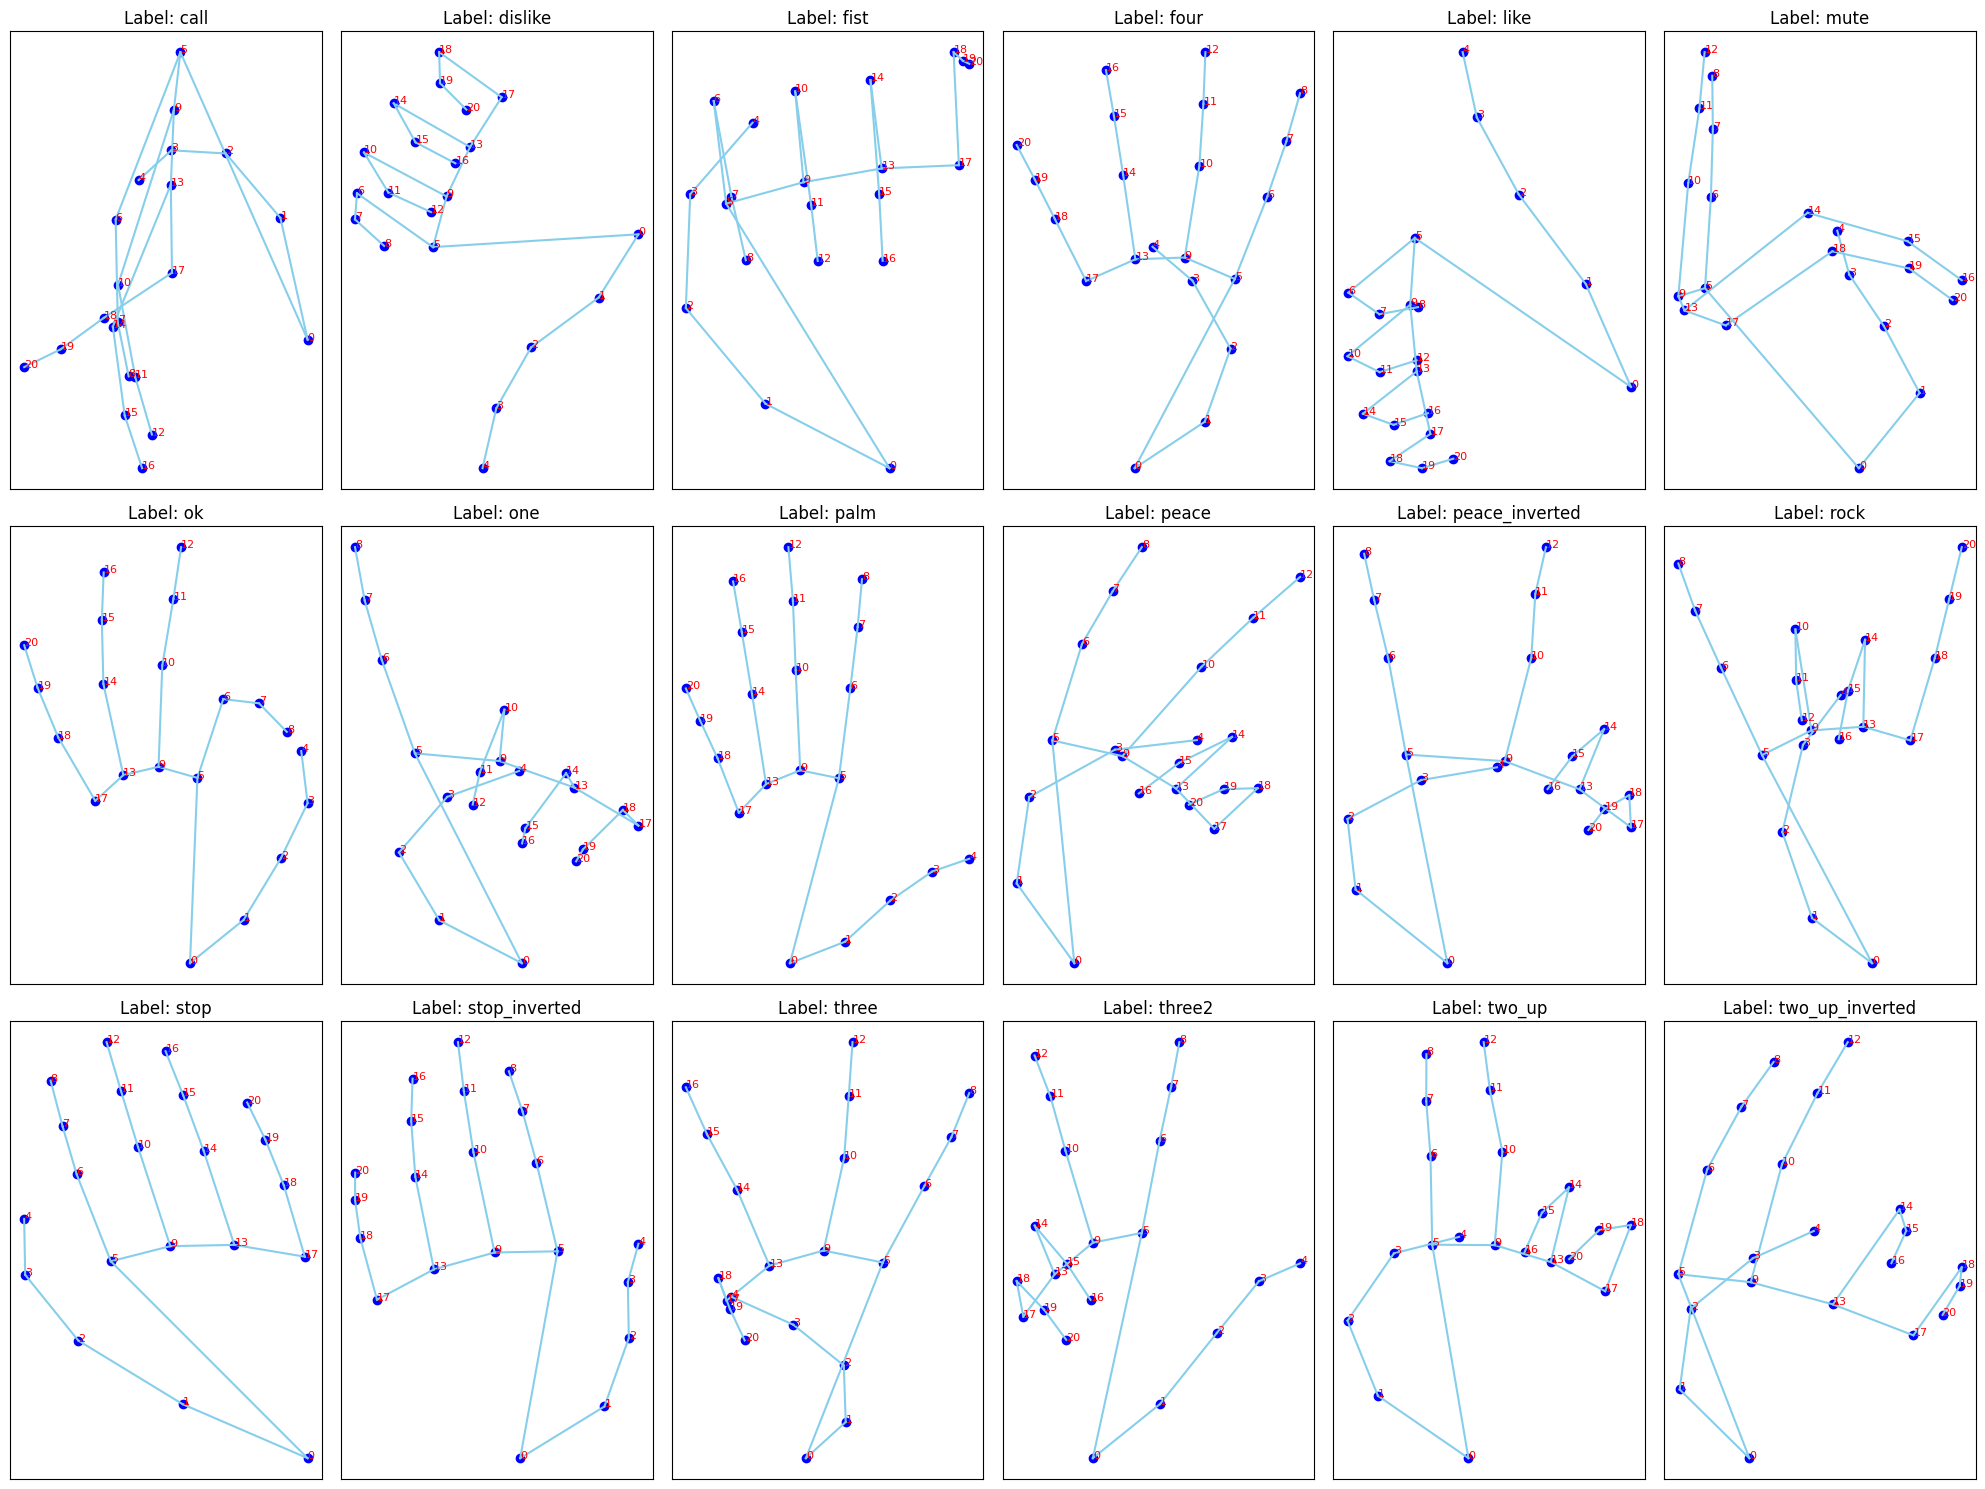

In [ ]:
plot_hand_landmarks(df)

# Data Preprocessing

## Data Exploration

**Check if the data is cleaned**

In [ ]:
# Check for null values
print(df.isna().sum().sort_values(ascending=False))

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64


In [ ]:
# Check for duplicate records
print(df.duplicated().sum())

0


In [ ]:
# Check for outliers
print(df.describe())

                 x1            y1            z1            x2            y2  \
count  25675.000000  25675.000000  2.567500e+04  25675.000000  25675.000000   
mean     201.958632    260.158527  1.272461e-07    202.517395    252.115322   
std       90.500333     76.533210  2.737932e-07     84.770933     75.384691   
min      -36.050926     45.722923 -2.029986e-06      7.184681     51.256840   
25%      124.110329    205.815950 -5.243216e-08    130.535929    197.999625   
50%      199.667847    255.181793  1.497277e-07    199.979530    247.113892   
75%      266.428482    304.991663  2.989988e-07    261.147457    296.850769   
max      633.556020    781.674469  1.876254e-06    606.232386    751.869416   

                 z2            x3            y3            z3            x4  \
count  25675.000000  25675.000000  25675.000000  25675.000000  25675.000000   
mean      -0.009465    202.862981    240.645966     -0.015946    203.025267   
std        0.010376     80.412089     74.721921    

## **Normalization**

In [ ]:
'''
- The detected hands have different scales and positions in the image.
- To overcome this problem recenter the hand landmarks (x,y) to make the origin the wrist point and divide all the landmarks by the mid-finger tip position.

With that all the detected hands will be similar in training and testing data.

- z location doesn’t need to be processed as it is already processed.

'''

x_wrist, y_wrist = df['x1'], df['y1']
x_mid, y_mid = df['x13'], df['y13']

df = df.copy()

i =1
for i in range(1, 22):
  df[f'x{i}'] = df[f'x{i}'] - x_wrist
  df[f'y{i}'] = df[f'y{i}'] - y_wrist

  df[f'x{i}'] = df[f'x{i}'] / x_mid
  df[f'y{i}'] = df[f'y{i}'] / y_mid

df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,0.0,0.0,-3.649205e-07,-0.022577,-0.038439,0.004224,-0.067860,-0.058768,0.005798,-0.112987,...,-0.169036,-0.006840,-0.020450,-0.204721,0.003053,-0.024577,-0.234969,0.008685,-0.026722,call
1,0.0,0.0,-2.345265e-07,-0.012495,-0.053144,-0.011102,0.058926,-0.104862,-0.021096,0.107634,...,0.430008,-0.012953,-0.038175,0.520406,-0.009810,-0.037336,0.604990,-0.009243,-0.036136,call
2,0.0,0.0,-2.417307e-07,0.033226,-0.073739,-0.000184,0.084116,-0.143944,-0.009687,0.119285,...,0.269757,0.032943,-0.044068,0.322050,0.043470,-0.040469,0.367617,0.047390,-0.038301,call
3,0.0,0.0,-1.233261e-07,-0.003506,-0.034615,-0.002824,0.012299,-0.067426,-0.008911,0.020067,...,0.223895,-0.007010,-0.027622,0.267296,-0.005898,-0.027863,0.303876,-0.006411,-0.027723,call
4,0.0,0.0,-1.622995e-07,-0.001294,-0.110079,-0.002884,0.015031,-0.245373,-0.008115,0.017717,...,0.178724,-0.075604,-0.025113,0.217087,-0.088218,-0.024087,0.248945,-0.105848,-0.023486,call


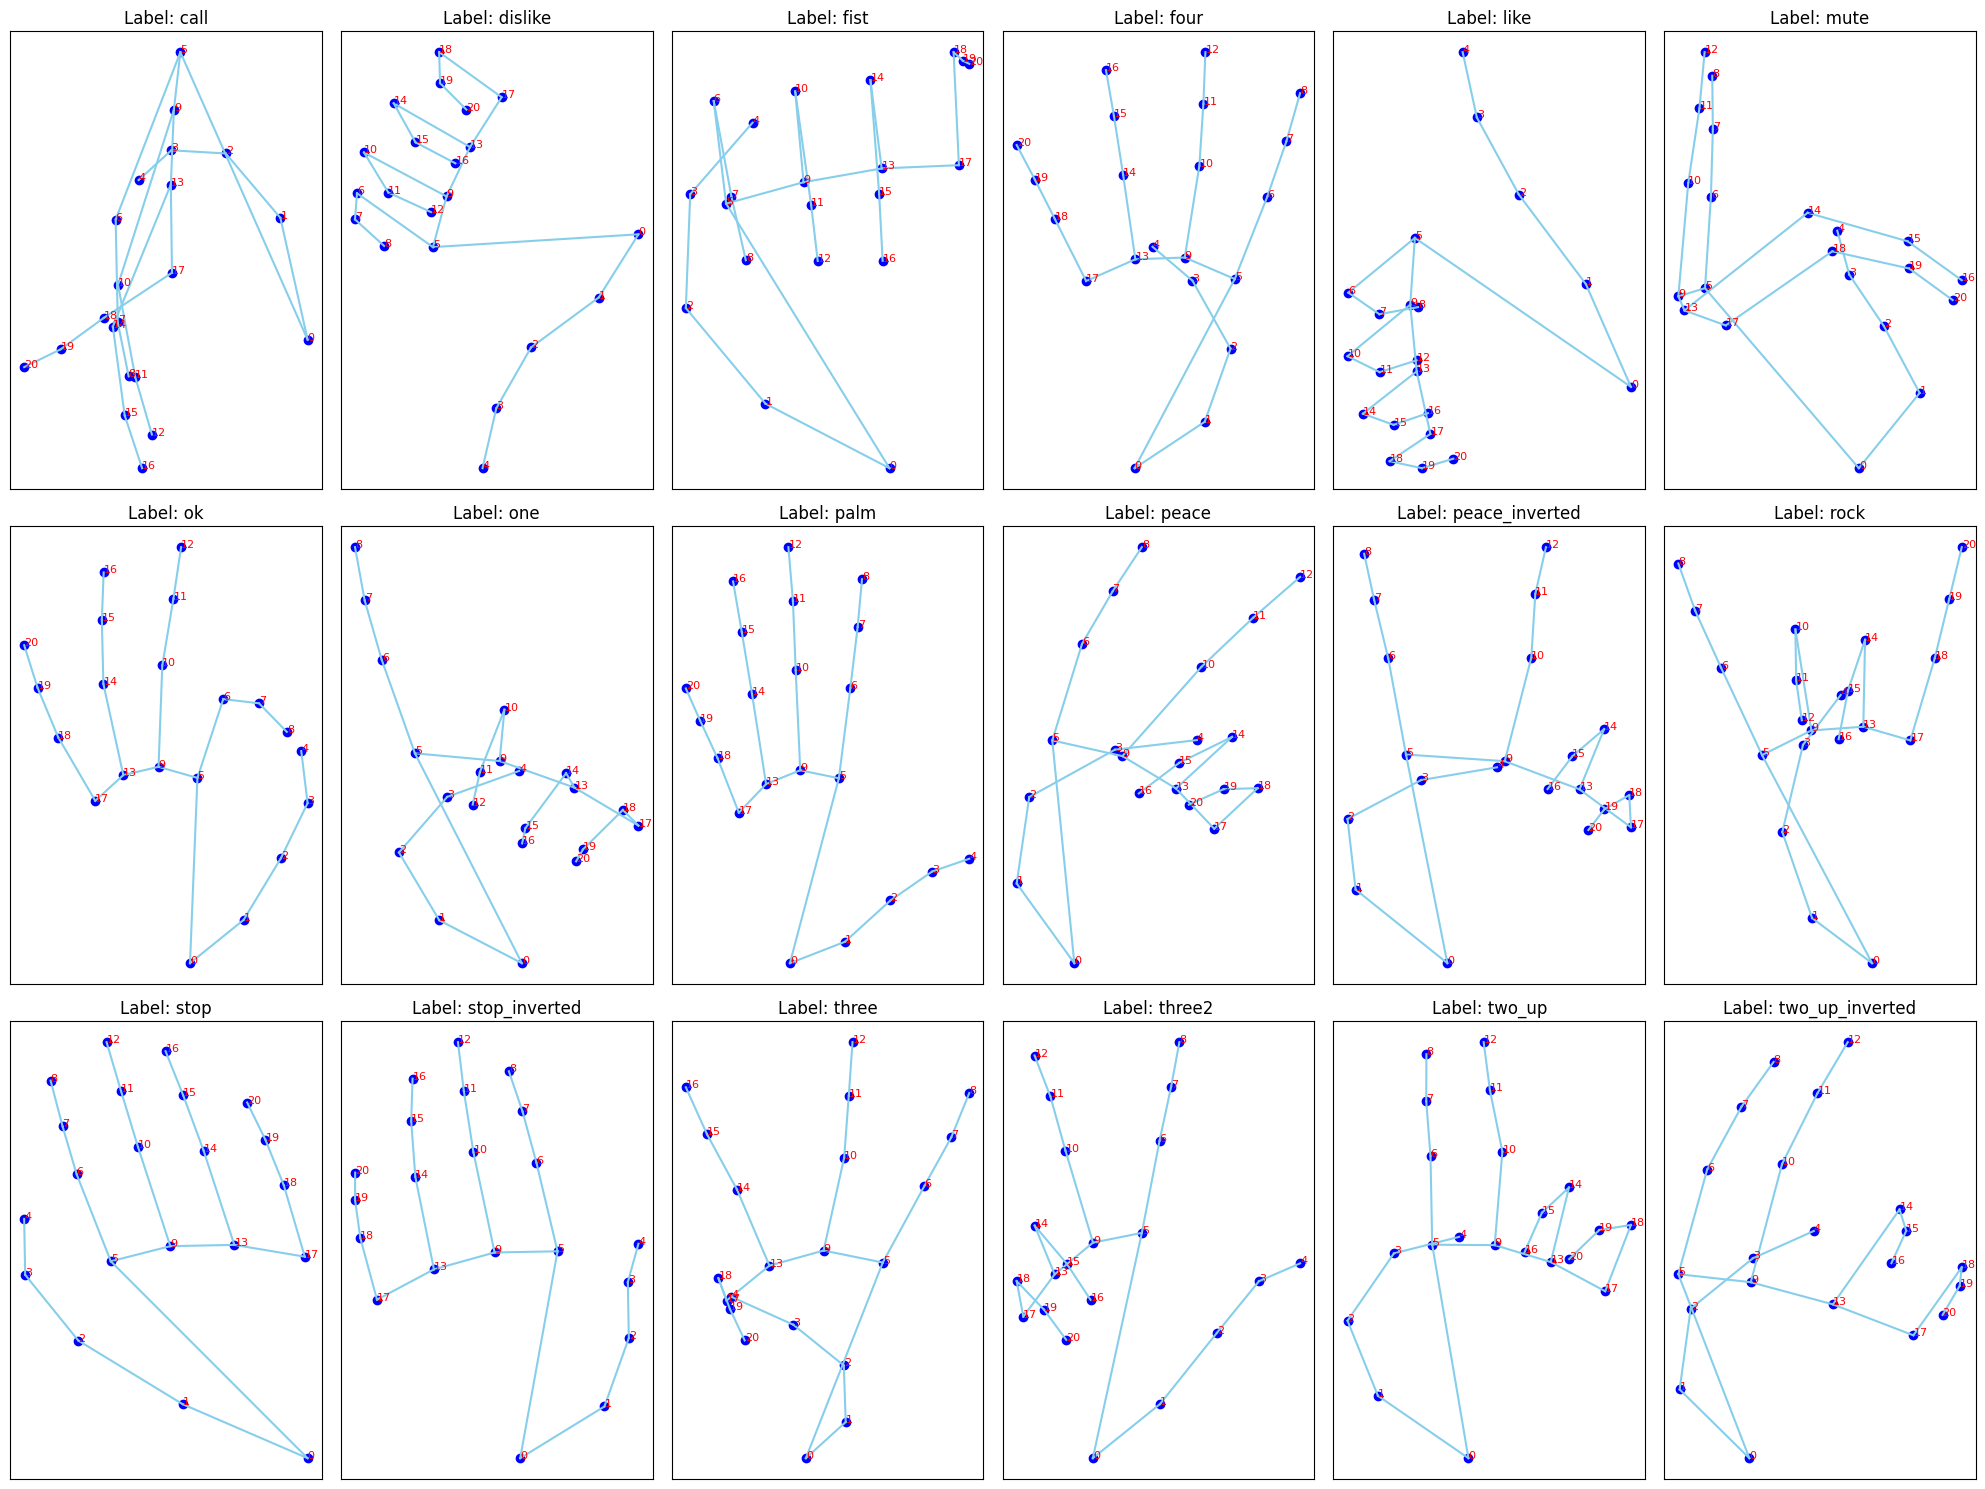

In [ ]:
plot_hand_landmarks(df)

## Label Encoding

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoder  = LabelEncoder()
df['label'] = label_encoder .fit_transform(df['label'])
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,0.0,0.0,-3.649205e-07,-0.022577,-0.038439,0.004224,-0.067860,-0.058768,0.005798,-0.112987,...,-0.169036,-0.006840,-0.020450,-0.204721,0.003053,-0.024577,-0.234969,0.008685,-0.026722,0
1,0.0,0.0,-2.345265e-07,-0.012495,-0.053144,-0.011102,0.058926,-0.104862,-0.021096,0.107634,...,0.430008,-0.012953,-0.038175,0.520406,-0.009810,-0.037336,0.604990,-0.009243,-0.036136,0
2,0.0,0.0,-2.417307e-07,0.033226,-0.073739,-0.000184,0.084116,-0.143944,-0.009687,0.119285,...,0.269757,0.032943,-0.044068,0.322050,0.043470,-0.040469,0.367617,0.047390,-0.038301,0
3,0.0,0.0,-1.233261e-07,-0.003506,-0.034615,-0.002824,0.012299,-0.067426,-0.008911,0.020067,...,0.223895,-0.007010,-0.027622,0.267296,-0.005898,-0.027863,0.303876,-0.006411,-0.027723,0
4,0.0,0.0,-1.622995e-07,-0.001294,-0.110079,-0.002884,0.015031,-0.245373,-0.008115,0.017717,...,0.178724,-0.075604,-0.025113,0.217087,-0.088218,-0.024087,0.248945,-0.105848,-0.023486,0


In [ ]:
df['label']

,label
0,0
1,0
2,0
3,0
4,0
...,...
25670,17
25671,17
25672,17
25673,17


In [ ]:
import pickle

# Save the encoder for later use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

['label_encoder.pkl']

## **Splitting Our dataset**

In [ ]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(df, test_size=0.3, random_state=42)
dev_df, test_df = train_test_split(dev_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Dev size: {len(dev_df)}")
print(f"Test size: {len(test_df)}")

Train size: 17972
Dev size: 3851
Test size: 3852


In [ ]:
train_df.to_csv('train_df.csv', index=False)
dev_df.to_csv('dev_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)